# Fit Fors2 Spectra and Photometry with DSPS
Restricted to FORS2 galaxies with GALEX photometry

Implement this fit using this `fors2tostellarpopsynthesis` package

- Author Joseph Chevalier
- Afflilation : IJCLab/IN2P3/CNRS
- Organisation : LSST-DESC
- creation date : 2024-01-10
- last update : 2024-01-10 : Initial version

Most functions are inside the package. This notebook inherits largely from `Fors2ToStellarPopSynthesis/docs/notebooks/fitters/FitFors2ManySpecLoop.ipynb` in the `fors2tostellarpopsynthesis` package.

## Imports and general settings

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import re
import pickle 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
import collections
from collections import OrderedDict
import re
import matplotlib.gridspec as gridspec
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

import jax
import jax.numpy as jnp
from jax import vmap
import jaxopt
import optax
jax.config.update("jax_enable_x64", True)
from interpax import interp1d

In [2]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  16

In [3]:
kernel = kernels.RBF(0.5, (8000, 20000.0))
gpr = GaussianProcessRegressor(kernel=kernel ,random_state=0)

## Filters

In [4]:
from fors2tostellarpopsynthesis.filters import FilterInfo

In [5]:
FLAG_REMOVE_GALEX = False
FLAG_REMOVE_GALEX_FUV = False

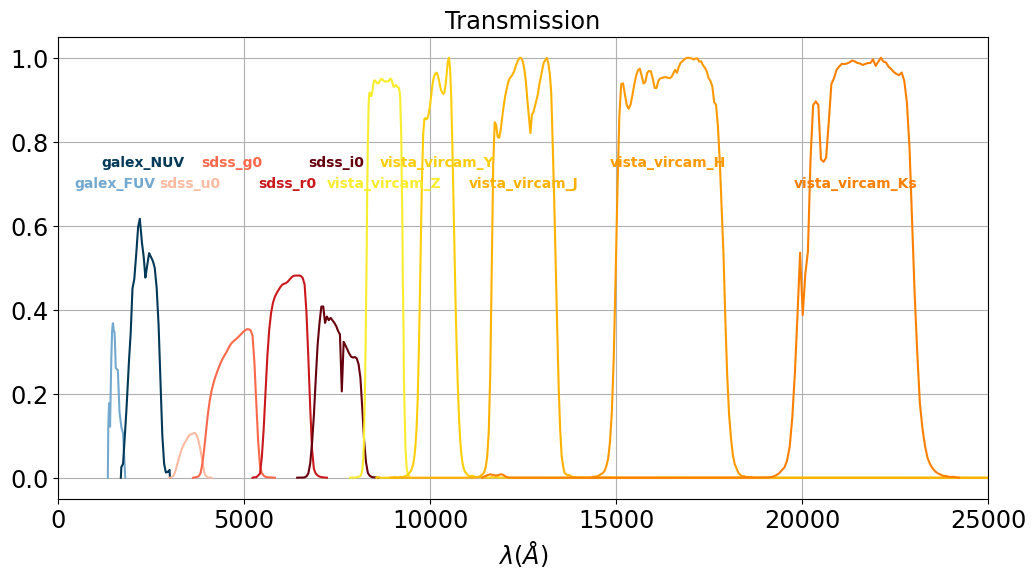

In [6]:
ps = FilterInfo()
ps.plot_transmissions()

## FORS2 and Starlight SPS extrapolation

In [7]:
from fors2tostellarpopsynthesis.fors2starlightio import Fors2DataAcess,\
                                                        SLDataAcess,\
                                                        convert_flux_torestframe,\
                                                        gpr

### Observed FORS2 data

['CLASS_STAR', 'DECJ2000', 'EXTINCTION_g', 'EXTINCTION_i', 'EXTINCTION_r', 'EXTINCTION_u', 'FLUXERR_GAAP_H', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_Ks', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_i', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_u', 'FLUX_GAAP_H', 'FLUX_GAAP_J', 'FLUX_GAAP_Ks', 'FLUX_GAAP_Y', 'FLUX_GAAP_Z', 'FLUX_GAAP_g', 'FLUX_GAAP_i', 'FLUX_GAAP_r', 'FLUX_GAAP_u', 'FLUX_RADIUS', 'ID', 'KIDS_TILE', 'MAGERR_GAAP_H', 'MAGERR_GAAP_J', 'MAGERR_GAAP_Ks', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_g', 'MAGERR_GAAP_i', 'MAGERR_GAAP_r', 'MAGERR_GAAP_u', 'MAG_GAAP_H', 'MAG_GAAP_J', 'MAG_GAAP_Ks', 'MAG_GAAP_Y', 'MAG_GAAP_Z', 'MAG_GAAP_g', 'MAG_GAAP_i', 'MAG_GAAP_r', 'MAG_GAAP_u', 'Nsp', 'RAJ2000', 'RT', 'RV', 'Rmag', 'Z_B', 'Z_ML', 'asep_galex', 'asep_kids', 'dec', 'dec_galex', 'eRV', 'fuv_flux', 'fuv_fluxerr', 'fuv_mag', 'fuv_magerr', 'lines', 'name', 'num', 'nuv_flux', 'nuv_fluxerr', 'nuv_mag', 'nuv_magerr', 'ra', 'ra_galex', 'redshift']


/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


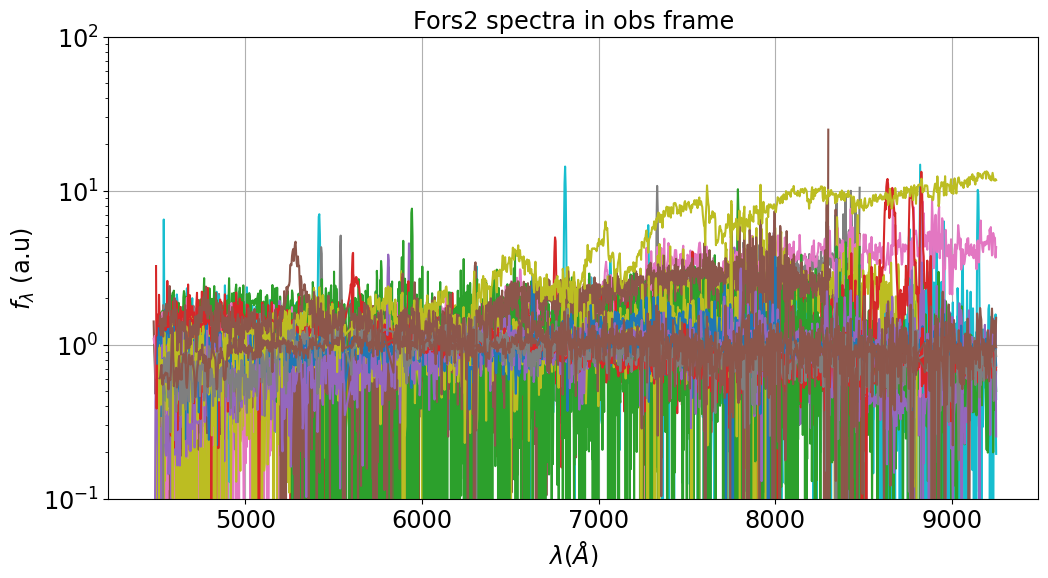

In [8]:
fors2 = Fors2DataAcess()
fors2_tags = fors2.get_list_of_groupkeys()
list_of_fors2_attributes = fors2.get_list_subgroup_keys()
print(list_of_fors2_attributes)
fors2.plot_allspectra()

### Extrapolated Starlight data

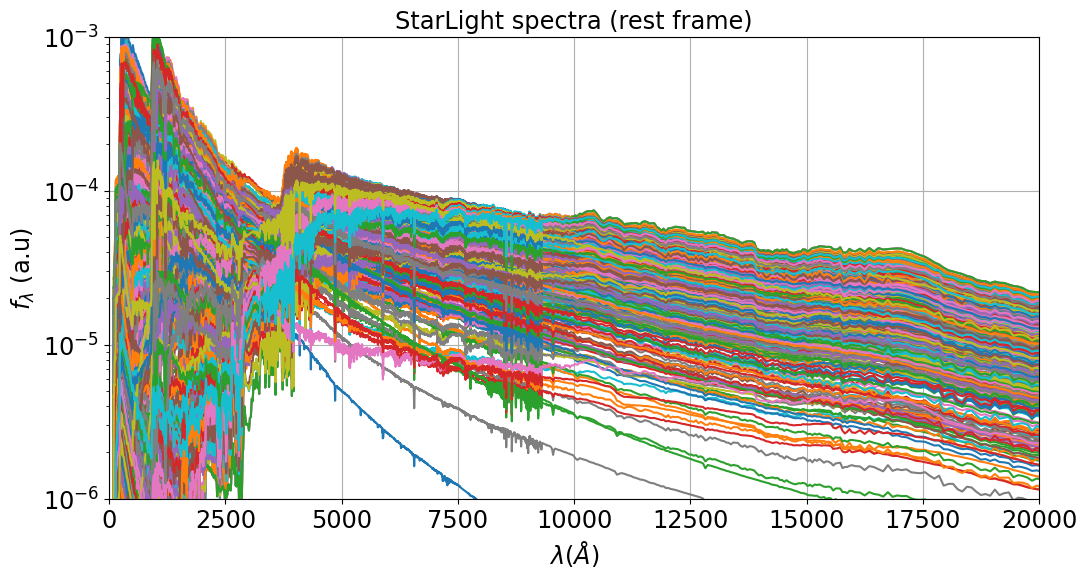

In [9]:
sl = SLDataAcess()
sl_tags = sl.get_list_of_groupkeys()
sl.plot_allspectra()

## Fitter with jaxopt

In [10]:
from fors2tostellarpopsynthesis.fitters.fitter_jaxopt import (lik_spec,\
                                                              lik_mag,\
                                                              lik_comb,\
                                                              get_infos_spec,\
                                                              get_infos_mag,\
                                                              get_infos_comb)

from fors2tostellarpopsynthesis.fitters.fitter_jaxopt import (SSP_DATA,\
                                                              mean_spectrum,\
                                                              mean_mags,\
                                                              mean_sfr,\
                                                              ssp_spectrum_fromparam)

from fors2tostellarpopsynthesis.fitters.fitter_util import (plot_fit_ssp_photometry,\
                                                            plot_fit_ssp_spectrophotometry,\
                                                            plot_fit_ssp_spectrophotometry_sl,\
                                                            plot_fit_ssp_spectroscopy,\
                                                            plot_SFH,\
                                                            rescale_photometry,\
                                                            rescale_spectroscopy,\
                                                            rescale_starlight_inrangefors2)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Parameters to fit

In [11]:
from fors2tostellarpopsynthesis.parameters import (SSPParametersFit,\
                                                   paramslist_to_dict)

## Select applicable spectra

In [12]:
selected_tags = []
for idx, tag in enumerate(fors2_tags):
    fors2_attr = fors2.getattribdata_fromgroup(tag)
    if np.isfinite(fors2_attr['fuv_mag']) and np.isfinite(fors2_attr['nuv_mag'])\
                                            and np.isfinite(fors2_attr['fuv_magerr'])\
                                            and np.isfinite(fors2_attr['nuv_magerr']) :
        selected_tags.append(tag)
len(selected_tags)

51

In [13]:
random_tags = np.random.choice(selected_tags, size=2, replace=False)

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 6000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 6000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


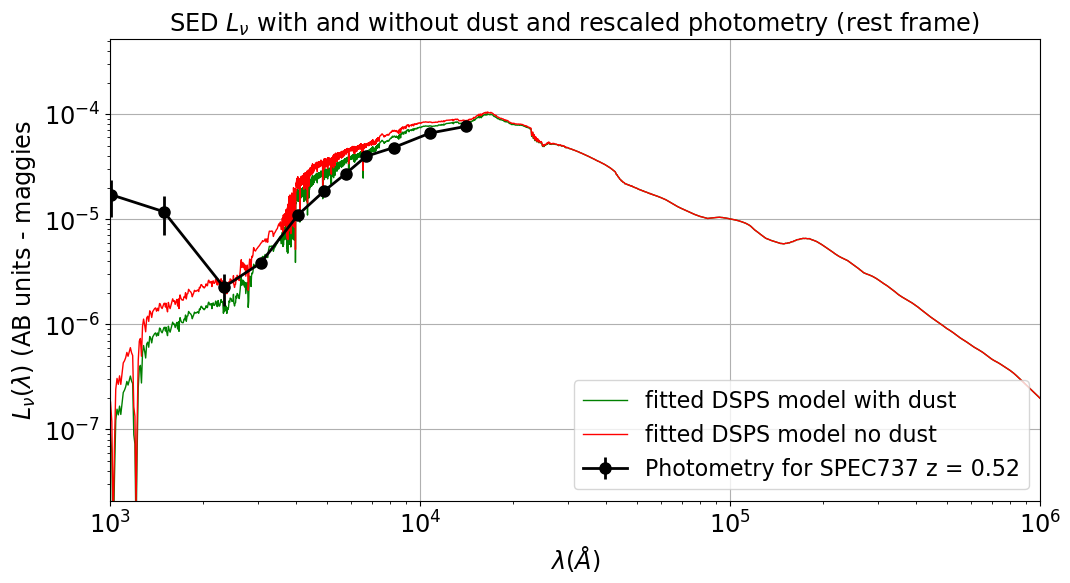

params_c: [12.76585841  0.06        3.51376258  1.5        12.25       -0.75
  1.20611769 -0.75        2.15232622  1.1        -0.60725    -0.91773
 -0.212307    0.59226961  3.         -0.34997571  1.        ] 
fun@min: 33334.78281352226 
jacob@min: [ 13172.70254747  -6234.01777927   -938.48465333 -11249.03447732
 -38428.61204373 -25255.90949613  -2036.2375773   -5356.05046521
     97.3283618       0.              0.              0.
      0.          24375.23868436    158.70097672  -3507.87912355
  45256.51949445]
params_cm: [12.76585841  0.06        3.51376258  1.5        12.25       -0.75
  1.20611769 -0.75        2.15232622  1.1        -0.60725    -0.91773
 -0.212307    0.59226961  3.         -0.34997571  1.        ] 
fun@min: 579.8193978208534 
jacob@min: [ 4.29804822e+03  2.16263763e+02  3.77775763e+01 -3.46681294e+02
  1.42684261e+03  5.72489084e+03 -4.65826481e+01  3.83929983e+02
 -5.60277081e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.95977440e+03 -1.

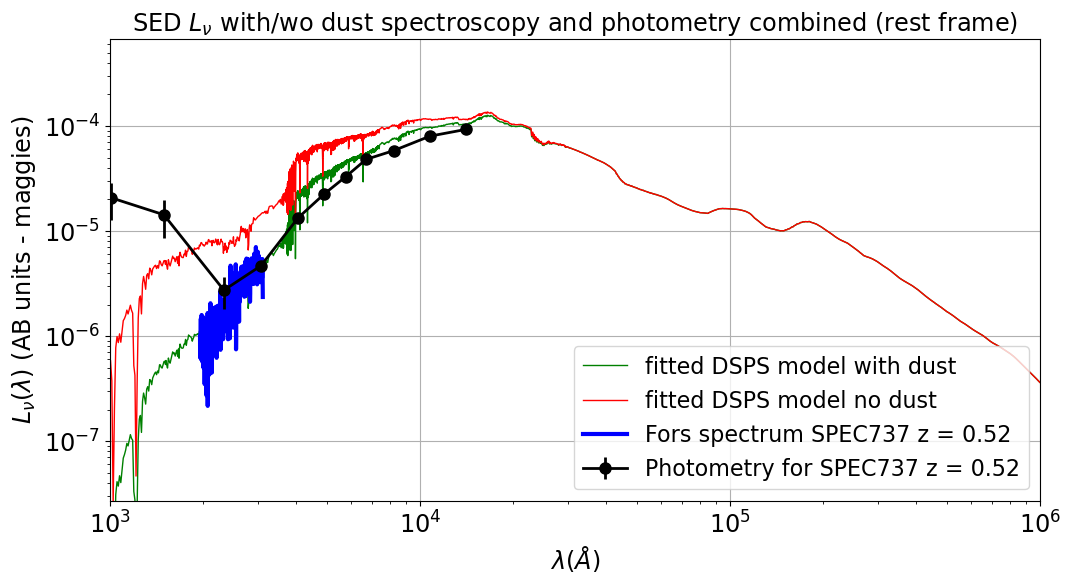

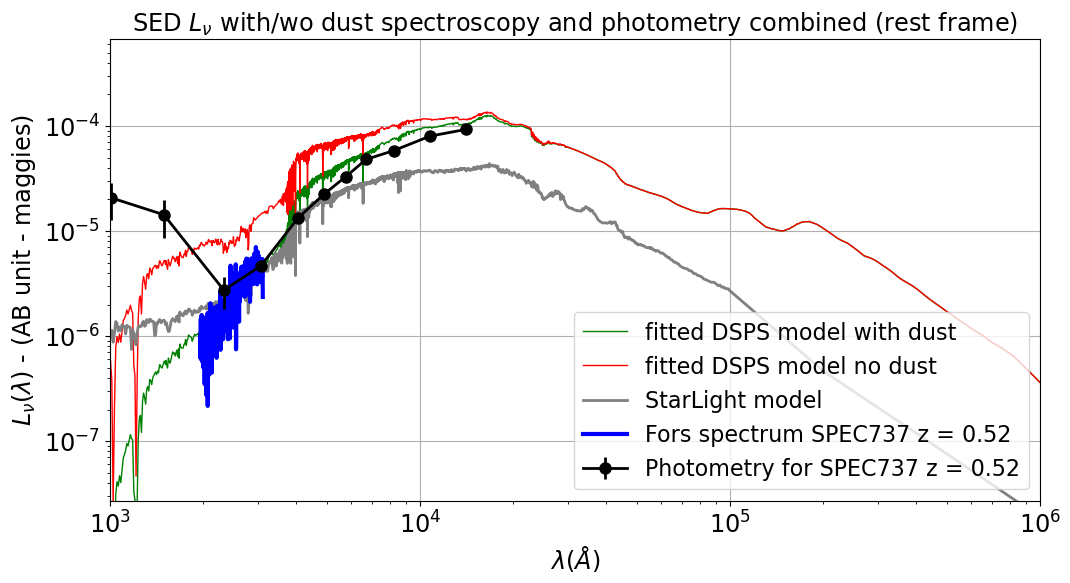

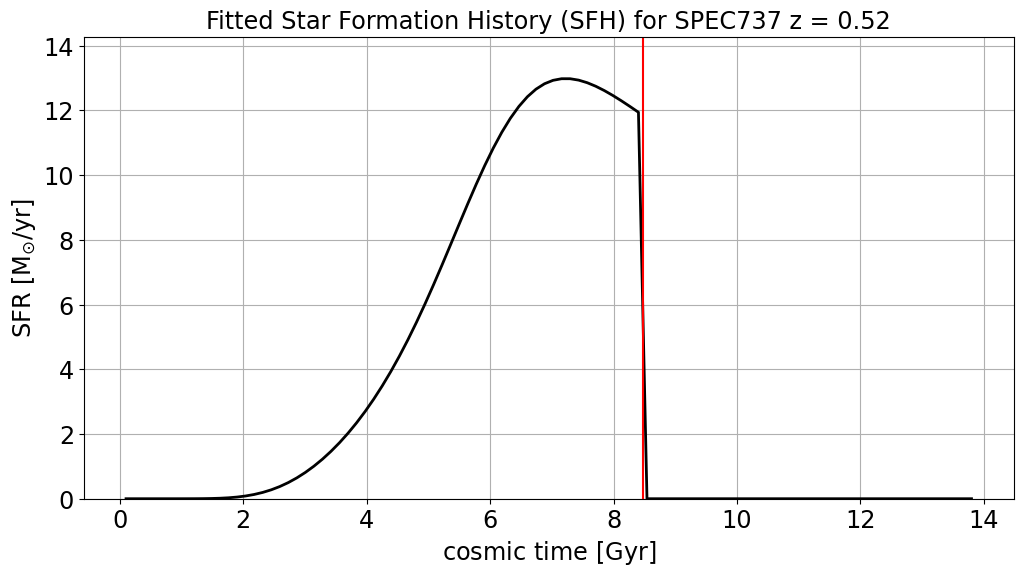

OrderedDict([('fors2name', 'SPEC737'), ('zobs', 0.52001), ('Nc', 774), ('Ns', 763), ('Nm', 11), ('funcmin_c', Array(33334.78281352, dtype=float64)), ('funcmin_m', Array(579.81939782, dtype=float64)), ('funcmin_s', Array(66089.74622922, dtype=float64)), ('MAH_lgmO', Array(12.76585841, dtype=float64)), ('MAH_logtc', Array(0.06, dtype=float64)), ('MAH_early_index', Array(3.51376258, dtype=float64)), ('MAH_late_index', Array(1.5, dtype=float64)), ('MS_lgmcrit', Array(12.25, dtype=float64)), ('MS_lgy_at_mcrit', Array(-0.75, dtype=float64)), ('MS_indx_lo', Array(1.20611769, dtype=float64)), ('MS_indx_hi', Array(-0.75, dtype=float64)), ('MS_tau_dep', Array(2.15232622, dtype=float64)), ('Q_lg_qt', Array(1.1, dtype=float64)), ('Q_qlglgdt', Array(-0.60725, dtype=float64)), ('Q_lg_drop', Array(-0.91773, dtype=float64)), ('Q_lg_rejuv', Array(-0.212307, dtype=float64)), ('AV', Array(0.59226961, dtype=float64)), ('UV_BUMP', Array(3., dtype=float64)), ('PLAW_SLOPE', Array(-0.34997571, dtype=float64))

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 6000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 6000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


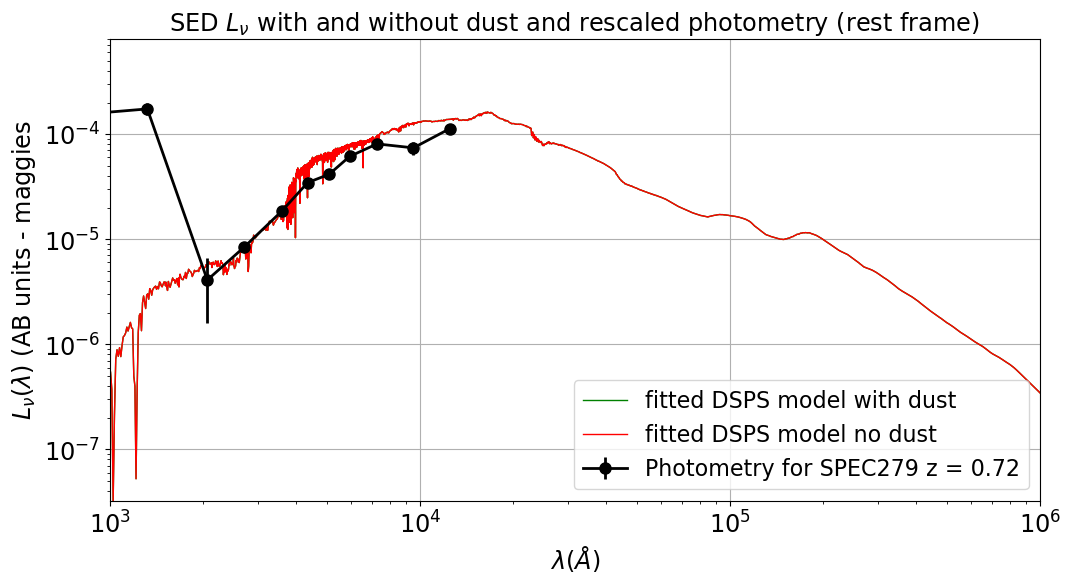

In [ ]:
for tag in random_tags:
    # extract most basic info
    selected_spectrum_number = int(re.findall("^SPEC(.*)", tag)[0])
    fors2_attr = fors2.getattribdata_fromgroup(tag)
    z_obs = fors2_attr['redshift']
    title_spec = f"{tag} z = {z_obs:.2f}"

    # retrieve magnitude data
    data_mags, data_magserr = fors2.get_photmagnitudes(tag)
    
    # get the Fors2 spectrum
    spec_obs = fors2.getspectrumcleanedemissionlines_fromgroup(tag)
    Xs = spec_obs['wl']
    Ys = spec_obs['fnu']
    EYs = spec_obs['bg']
    EYs_med = spec_obs['bg_med']
    
    # convert to restframe
    Xspec_data, Yspec_data = convert_flux_torestframe(Xs, Ys, z_obs)
    EYspec_data = EYs * (1+z_obs)
    EYspec_data_med = EYs_med * (1+z_obs)
    
    # smooth the error over the spectrum
    fit_res = gpr.fit(Xspec_data[:, None], EYspec_data)
    EYspec_data_sm = gpr.predict(Xspec_data[:, None], return_std=False)
    
    # need to increase error to decrease chi2 error
    EYspec_data_sm *= 2
    
    # parameters for fit
    p = SSPParametersFit()
    init_params = p.INIT_PARAMS
    params_min = p.PARAMS_MIN
    params_max = p.PARAMS_MAX

    # Choose filters with mags without Nan
    NoNaN_mags = np.intersect1d(np.argwhere(~np.isnan(data_mags)).flatten(),\
                                np.argwhere(~np.isnan(data_magserr)).flatten())
    
    # selected indexes for filters
    index_selected_filters = NoNaN_mags

    if FLAG_REMOVE_GALEX:
        galex_indexes = np.array([0,1])
        index_selected_filters = np.setdiff1d(NoNaN_mags, galex_indexes)
    elif FLAG_REMOVE_GALEX_FUV:
        galex_indexes = np.array([0])
        index_selected_filters = np.setdiff1d(NoNaN_mags, galex_indexes)    
        
    
    # Select filters
    XF = ps.get_2lists()
    NF = len(XF[0])
    list_wls_f_sel = []
    list_trans_f_sel = []
    list_name_f_sel = []
    list_wlmean_f_sel = []

    for index in index_selected_filters:
        list_wls_f_sel.append(XF[0][index])
        list_trans_f_sel.append(XF[1][index])
        the_filt = ps.filters_transmissionlist[index]
        the_wlmean = the_filt.wave_mean
        list_wlmean_f_sel.append(the_wlmean)
        list_name_f_sel.append(ps.filters_namelist[index])
    
    list_wlmean_f_sel = jnp.array(list_wlmean_f_sel)
    Xf_sel = (list_wls_f_sel, list_trans_f_sel)
    
    # get the magnitudes and magnitude errors
    data_selected_mags =  jnp.array(data_mags[index_selected_filters])
    data_selected_magserr = jnp.array(data_magserr[index_selected_filters])
    
    #fit with magnitudes only
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun = lik_mag, method = "L-BFGS-B")
    res_m = lbfgsb.run(init_params,\
                       bounds=(params_min, params_max),\
                       xf = Xf_sel,\
                       mags_measured = data_selected_mags,\
                       sigma_mag_obs = data_selected_magserr,\
                       z_obs = z_obs)
    params_m, fun_min_m, jacob_min_m, inv_hessian_min_m = get_infos_mag(res_m,\
                                                                        lik_mag,\
                                                                        xf = Xf_sel,\
                                                                        mgs = data_selected_mags,\
                                                                        mgse = data_selected_magserr,\
                                                                        z_obs=z_obs)
    #print("params:",params_m,"\nfun@min:",fun_min_m,"\njacob@min:",jacob_min_m)
    
    # Convert fitted parameters into a dictionnary
    dict_params_m = paramslist_to_dict(params_m, p.PARAM_NAMES_FLAT) 
    
    # rescale photometry datapoints
    xphot_rest, yphot_rest, eyphot_rest, factor = rescale_photometry(dict_params_m,\
                                                                     list_wlmean_f_sel,\
                                                                     data_selected_mags,\
                                                                     data_selected_magserr,\
                                                                     z_obs)
    
    # plot model with photometry
    plot_fit_ssp_photometry(dict_params_m,\
                            list_wlmean_f_sel,\
                            data_selected_mags,\
                            data_selected_magserr,\
                            z_obs,\
                            subtit = title_spec,\
                            ax=None)
    
    #rescale Fors2 spectroscopy
    Xspec_data_rest, Yspec_data_rest, EYspec_data_rest, factor = rescale_spectroscopy(dict_params_m,\
                                                                                      Xspec_data,\
                                                                                      Yspec_data,\
                                                                                      EYspec_data,\
                                                                                      z_obs)
    '''
    # fit spectroscopy
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun = lik_spec, method = "L-BFGS-B")
    res_s = lbfgsb.run(init_params,\
                       bounds = (params_min, params_max),\
                       wls = Xspec_data_rest,\
                       F = Yspec_data_rest,\
                       sigma_obs = EYspec_data_rest,\
                       z_obs = z_obs)
    params_s, fun_min_s, jacob_min_s, inv_hessian_min_s = get_infos_spec(res_s,\
                                                                         lik_spec,\
                                                                         wls = Xspec_data,\
                                                                         F = Yspec_data,\
                                                                         eF = EYspec_data,\
                                                                         z_obs = z_obs)
    #print("params:",params_s,"\nfun@min:",fun_min_s,"\njacob@min:",jacob_min_s)

    # Convert fitted parameters with spectroscopy into a dictionnary
    dict_params_s = paramslist_to_dict( params_s,p.PARAM_NAMES_FLAT) 
    
    # plot fit for spectroscopy only
    plot_fit_ssp_spectroscopy(dict_params_s,\
                              Xspec_data_rest,\
                              Yspec_data_rest,\
                              EYspec_data_rest,\
                              z_obs,\
                              subtit = title_spec)
    '''
    
    # combining spectro and photometry
    Xc = [Xspec_data_rest, Xf_sel]
    Yc = [Yspec_data_rest, data_selected_mags]
    EYc = [EYspec_data_rest, data_selected_magserr]
    weight_spec = 0.5
    Ns = len(Yspec_data_rest)
    Nm = len(data_selected_mags)
    Nc = Ns+Nm
    
    # do the combined fit
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun = lik_comb, method = "L-BFGS-B")
    res_c = lbfgsb.run(init_params,\
                       bounds = (params_min, params_max),\
                       xc = Xc,\
                       datac = Yc,\
                       sigmac = EYc,\
                       z_obs = z_obs,\
                       weight = weight_spec)
    params_c, fun_min_c, jacob_min_c, inv_hessian_min_c = get_infos_comb(res_c,\
                                                                         lik_comb,\
                                                                         xc = Xc,\
                                                                         datac = Yc,\
                                                                         sigmac = EYc,\
                                                                         z_obs = z_obs,\
                                                                         weight = weight_spec)
    params_cm, fun_min_cm, jacob_min_cm, inv_hessian_min_cm  = get_infos_mag(res_c,\
                                                                             lik_mag,\
                                                                             xf = Xf_sel,\
                                                                             mgs = data_selected_mags,\
                                                                             mgse = data_selected_magserr,\
                                                                             z_obs = z_obs)
    params_cs, fun_min_cs, jacob_min_cs, inv_hessian_min_cs = get_infos_spec(res_c,\
                                                                             lik_spec,\
                                                                             wls = Xspec_data_rest,\
                                                                             F = Yspec_data_rest,\
                                                                             eF = EYspec_data_rest,\
                                                                             z_obs = z_obs)
    print("params_c:", params_c, "\nfun@min:", fun_min_c, "\njacob@min:", jacob_min_c) #,"\n invH@min:",inv_hessian_min_c)
    print("params_cm:", params_cm, "\nfun@min:", fun_min_cm, "\njacob@min:", jacob_min_cm)
    print("params_cs:", params_cs, "\nfun@min:", fun_min_cs, "\njacob@min:", jacob_min_cs)

    #save to dictionary
    dict_out = OrderedDict()
    dict_out["fors2name"] = tag
    dict_out["zobs"] = z_obs
    dict_out["Nc"] = Nc
    dict_out["Ns"] = Ns
    dict_out["Nm"] = Nm
    dict_out["funcmin_c"] = fun_min_c
    dict_out["funcmin_m"] = fun_min_cm
    dict_out["funcmin_s"] = fun_min_cs
       
    # convert into a dictionnary
    dict_params_c = paramslist_to_dict(params_c, p.PARAM_NAMES_FLAT) 
    dict_out.update(dict_params_c)
        
    # plot the combined fit
    plot_fit_ssp_spectrophotometry(dict_params_c,\
                                   Xspec_data_rest,\
                                   Yspec_data_rest,\
                                   EYspec_data_rest,\
                                   xphot_rest,\
                                   yphot_rest,\
                                   eyphot_rest,\
                                   z_obs = z_obs,\
                                   subtit = title_spec )
    
    #load starlight spectrum
    dict_sl = sl.getspectrum_fromgroup(tag)
    
    # rescale starlight spectrum
    w_sl, fnu_sl, _ = rescale_starlight_inrangefors2(dict_sl["wl"],\
                                                     dict_sl["fnu"],\
                                                     Xspec_data_rest,\
                                                     Yspec_data_rest)
    
    # plot starlight
    plot_fit_ssp_spectrophotometry_sl(dict_params_c,\
                                      Xspec_data_rest,\
                                      Yspec_data_rest,\
                                      EYspec_data_rest,\
                                      xphot_rest,\
                                      yphot_rest,\
                                      eyphot_rest,\
                                      w_sl,\
                                      fnu_sl,\
                                      z_obs = z_obs,\
                                      subtit = title_spec)
    
    # plot SFR
    plot_SFH(dict_params_c, z_obs, subtit = title_spec, ax=None)
    
    #save parameters
    filename_params = f"fitparams_{tag}_galex.pickle"
    with open(filename_params, 'wb') as f:
        print(dict_out)
        pickle.dump(dict_out, f)

Photometry in UV is not consistant with the extrapolated spectrum. Further checks are needed.
A good start would be to actually triple-check the correspondance between FORS2 spectra and sources of photometry.